In [251]:
from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits



file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T1\2.cine")
# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=100)

# Normalize the grayscale video to [0, 1] brightness range
video = video / brightness_levels

json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T1\config.json")
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

data

Video Info - Width: 768, Height: 768, Frames: 100
The injector has 10 plumes.
The nozzle is centred at (389.14, 377.44) in image coordinates.


{'plumes': 10,
 'offset': 330.61,
 'centre_x': 389.142,
 'centre_y': 377.44,
 'inner_radius': 0.0,
 'outer_radius': 130.0}

In [252]:
from OSCC_postprocessing.playback.video_playback import *
play_video_cv2(video, intv=100)

In [253]:
# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

In [254]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


In [255]:
# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy


In [256]:
from OSCC_postprocessing.filters.bilateral_filter import *
# upload to gpu or do nothing with cpu
video = xp.asarray(video)

# pakaged pre-processing calling, use this in real impelmentations
# foreground = pre_processing_mie(video, division=False)

# Explicitly coding for showing the whole process

# We do not divide by the first frame to fix lighting
# In the videos I process, they have some strong bright spots by reflections
# If didivde, they become some dark spots. 


'''
bilateral_filtered = bilateral_filter_video_volumetric_chunked_halo(
    video, (3, 5, 5), 3, 3
)
'''
# Bilateral filtering
if use_gpu:
    bilateral_filtered = bilateral_filter_video_cupy(video, 7, 3, 3)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(video), 7, 3, 3)



# Take the filtered first frame as background 
bkg = bilateral_filtered[0]
bkg[bkg == 0] = 1e-9
bkg[bkg == cp.nan] = 1e-9

# Foreground is the filtered video - filtered background
foreground = bilateral_filtered - bilateral_filtered[0][None, :, :]



In [257]:
# Visualize the filtering results
# play_video_cv2(video.get())
play_videos_side_by_side((video.get(), bilateral_filtered.get(), foreground.get()), intv=100) # type: ignore


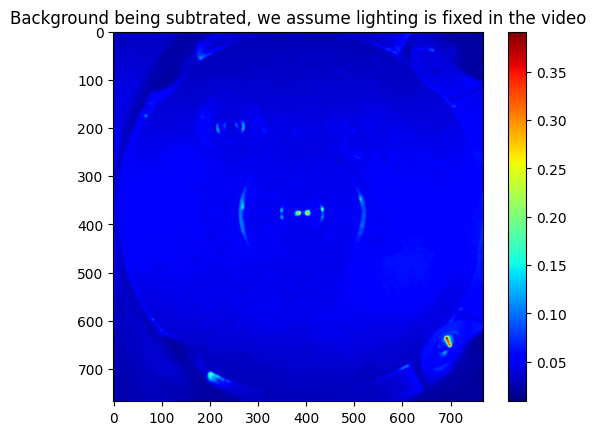

In [258]:
import matplotlib.pyplot as plt
plt.title("Background being subtrated, we assume lighting is fixed in the video")
plt.imshow(bkg.get(), cmap="jet")
plt.colorbar()

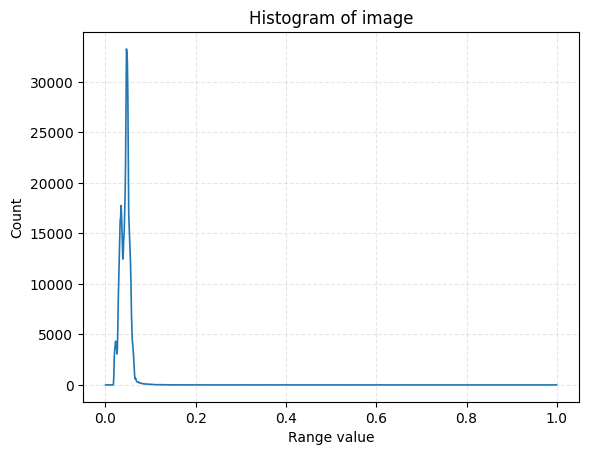

In [259]:
# Histogram of the background image
imhist(bkg.get())

In [260]:
from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu




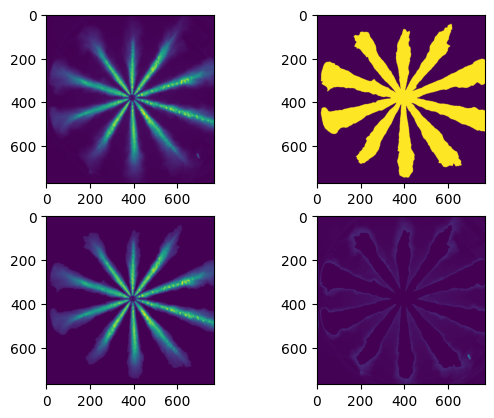

In [261]:
px_range_map = cp.max(foreground, axis=0) - cp.min(foreground, axis=0)


mask, _ = triangle_binarize_from_float(to_numpy(px_range_map))
mask = keep_largest_component(mask)
mask = binary_fill_holes(mask)
mask = cp.asarray(mask)


# Visualize max pixel range of each pixel in the video vs the mask made out of it
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(px_range_map.get())
ax[0,1].imshow(mask.get())
ax[1,0].imshow((mask*px_range_map).get())
ax[1,1].imshow((px_range_map*(1- mask)).get())
# fig.set_title("Max pixel range of each pixel in the video vs the mask made out of it")


In [275]:
# visualize the masked video
foreground_masked = mask[None, :, :] * foreground

play_video_cv2(foreground_masked.get())

# play_video_cv2(10*xp.abs(foreground_masked-video).get())

(389.142, 377.44)

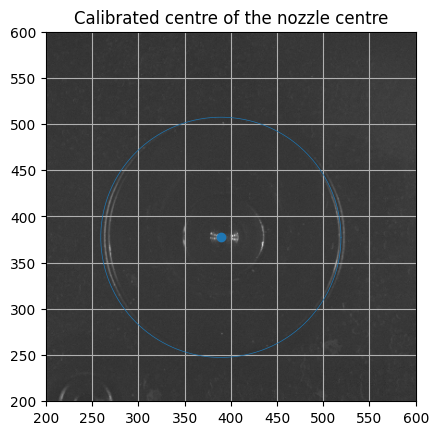

In [ ]:
r = 130

# Displaying the clibration
plt.imshow(video[0].get()**0.5, cmap="gray")
plt.scatter(centre[0], centre[1])

theta = np.linspace(0, 2*np.pi, 400)

x0, y0 = centre[0] , centre[1]

x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

plt.plot(x, y, linewidth="0.5")
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([200, 600])
plt.ylim([200, 600])
plt.title("Calibrated centre of the nozzle centre")
centre


Text(0, 0.5, 'Frame number')

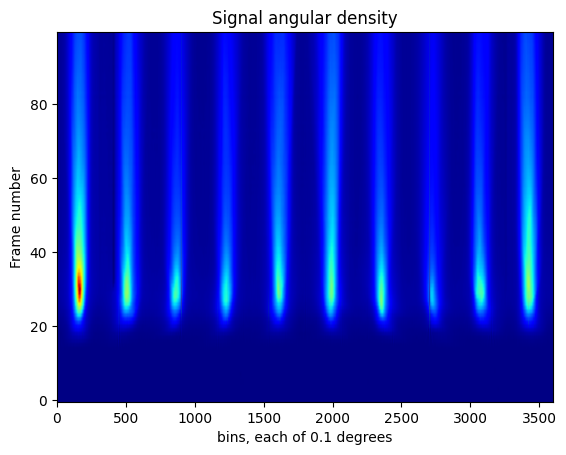

In [264]:
bins = 3600
start_time = time.time()
_, signal, _ = angle_signal_density_auto(foreground, centre[0], centre[1], N_bins=bins)

plt.imshow(signal, aspect="auto", origin="lower", cmap="jet")
plt.title("Signal angular density")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Frame number")

Estimated offset from FFT: 17.125 degrees


Text(0, 0.5, 'Total intensity in all frames (sum)')

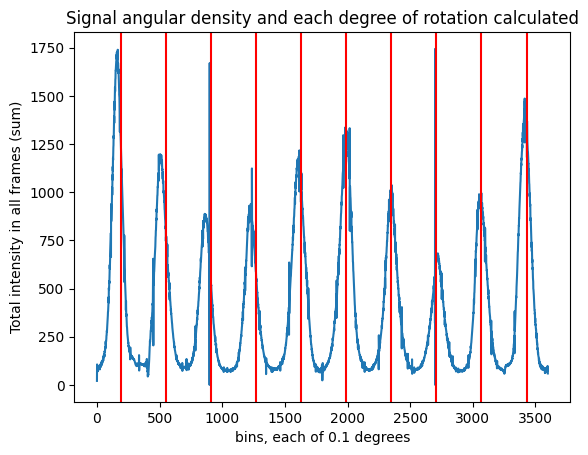

In [265]:
# Offset is calculated by the sum of angular signal in all frames
# (See the blue curve below)
# And setting the fundamental frequency to *number of plumes*,
# Find the best offset for this periodicity 

offset = estimate_offset_from_fft(signal, number_of_plumes)
if offset:
    print(f"Estimated offset from FFT: {offset:.3f} degrees")

angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - offset

# foreground = xp.asarray(foreground, dtype=xp.float32)
summed_angular_density_all_frames = np.sum(signal, axis=0)
plt.plot(summed_angular_density_all_frames)

shift = np.sum(angles < 0) * 360.0/number_of_plumes

for idx, angle in enumerate(angles):
    plt.axvline((bins/360.0)*(angle+shift), color="r")

plt.title("Signal angular density and each degree of rotation calculated")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Total intensity in all frames (sum)")
    

In [266]:
# Rotation
# 
#  

# Frames, Height, Width
F, H, W = video.shape

# Allocate collector
segments = []

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H // 4, W//2)


for idx, angle in enumerate(angles):
    segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            foreground,
            # centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
            (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
            angle,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
        )
    segments.append(segment)

segments = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)

In [267]:
# Show a random segment
idx = np.random.random_integers(0, segments.shape[0]-1)
play_video_cv2(segments[idx].get())

C:\Users\Jiang\AppData\Local\Temp\ipykernel_38136\2590765415.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  idx = np.random.random_integers(0, segments.shape[0]-1)


Text(0, 0.5, 'image coordinates y')

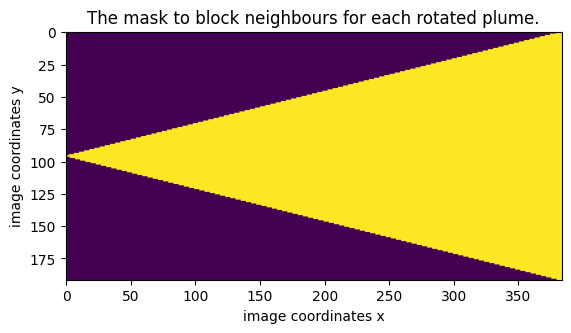

In [268]:
plume_mask = generate_plume_mask(ir_, or_, segments.shape[3], segments.shape[2])
plt.imshow(plume_mask)
plt.title("The mask to block neighbours for each rotated plume.")
plt.xlabel("image coordinates x")
plt.ylabel("image coordinates y")

In [269]:
# Array shape fitting and upload to the GPU
masks = cp.asarray(plume_mask[None, None, :, :])
# Apply the rotated masks
segments_masked = masks*segments

# Show a random segment
idx = np.random.random_integers(0, segments_masked.shape[0]-1)
play_video_cv2(segments_masked[idx].get())

C:\Users\Jiang\AppData\Local\Temp\ipykernel_38136\3552097655.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  idx = np.random.random_integers(0, segments_masked.shape[0]-1)
